# Parameter sensitivity analysis

[The cluster selection strategies notebook](./demo_selection_strategies.ipynb)
demonstrates ``plscan`` is less sensitive to the ``min_samples`` parameter ($k$)
than ``hdbscan``. This notebook runs a more comprehensive parameter sensitivity
analysis to determine whether that pattern holds on other datasets. This
parameter sensitivity analysis tells us how the clustering quality changes as a
result of changing $k$. The resulting value is independent of $k$ itself.
Instead they relate to a change in $k$: $\Delta k$!

We apply the analysis [Peng et al.
2022](https://www.nature.com/articles/s41467-022-33136-9#Sec18) used to evaluate
their clustering algorithm. They modified a "Latin-Hypercube
One-factor-At-a-Time (LH-OAT)" analysis. This sounds more complicated than it
is, especially for algorithms with a single parameter. The steps are as follows:

- Choose a parameter $k$ and divided its value-space in regularly sized
  segments.
- Choose a constant perturbation $\Delta v$ to evaluate.
- Sample values $v$ in each segment. We denote the set of sampled values with
  $V$. 
- Perturb the sampled values with $\pm \Delta v$, randomly choosing the positive
  or negative direction.
- Compute the algorithm's clustering quality scores at $v$ and $v \pm \Delta v$.
  For example, using the
  [ARI](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html).
  We denote this score as $ARI(k=v)$, indicating a score at parameter value
  $k=v$.
- Compute the sensitivity at $\Delta v$ using: 
$$
  s_{\Delta v} = \frac{1}{|V|} \sum_{v \in V} \left|\frac{ARI(k=v \pm \Delta v) - ARI(k=v)} {ARI(k=v \pm\Delta v) + ARI(k=v)}\right|. 
$$

We want to evaluate the sensitivity for multiple perturbation sizes $\Delta v$,
algorithm configurations, and datasets. Our implementation splits the work in
three stages and considers several clustering quality measures:

1. Sample the parameter and perturbations, collecting all parameter values to
   evaluate.
2. Compute the algorithms' clustering quality measures values on all datasets
   with the collected parameter values. Store these values!
3. Use the computed quality measures values to compute average sensitivities for
   each perturbation size.

In [1]:
import warnings

import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import product
from scipy.stats import rankdata
from collections import defaultdict
from sklearn.datasets import fetch_openml, load_iris as sk_load_iris

from umap import UMAP
from lensed_umap import embed_graph

from plscan import PLSCAN
from hdbscan import HDBSCAN
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score

from lib.plotting import *
from lib.drawing import regplot_lowess_ci

_ = configure_matplotlib()  # uses latex for text rendering!

## 1. Sample parameter values and perturbations

This cell performs the parameter value sampling and applies perturbations at
multiple sizes. The process is repeated five times (vectorized) and all unique
parameter values required for the sensitivity computation are collected.

Perturbations that create invalid values (<2) are ignored!

In [2]:
# configuration
repeats = 5
num_segments = 10
min_sample_range = (2, 50)
deltas = np.array([[2], [5], [10]])

# sampled values
segments = np.linspace(*min_sample_range, num_segments + 1, dtype=int)
samples = np.random.uniform(segments[:-1], segments[1:], size=(repeats, num_segments))
min_sample_sizes = np.round(samples).astype(int).T

# perturbed values
directions = np.random.choice((-1, 1), size=(deltas.shape[0], num_segments, repeats))
perturbations = directions * deltas[:, :, np.newaxis]
new_values = min_sample_sizes[np.newaxis, :, :] + perturbations

# all values to evaluate
all_values = np.concatenate((min_sample_sizes.flatten(), new_values.flatten()))
all_values = np.unique(all_values)
all_values = all_values[(all_values >= 2)]

np.save("data/generated/benchmark_sensitivity_deltas.npy", deltas)
np.save("data/generated/benchmark_sensitivity_min_sizes.npy", min_sample_sizes)
np.save("data/generated/benchmark_sensitivity_perturbed_values.npy", new_values)

## 2. Compute quality measures

This stage computes clustering quality measures at the sampled parameter values.

First, we configure the datasets. This step assumes all dataset have been
downloaded and pre-processed before running this notebook. See instructions at
`docs/data/[data-set]/README.md`!

In [3]:
def load_iris():
    X, y = sk_load_iris(return_X_y=True)
    return X, y.astype(np.intp)


def load_mnist():
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True)
    return X, y.cat.codes.to_numpy().astype(np.intp)


def load_fashion_mnist():
    X, y = fetch_openml("Fashion-MNIST", version=1, return_X_y=True)
    return X, y.cat.codes.to_numpy().astype(np.intp)


def local_data_loader(folder):
    """Load data from a specified folder in the data directory.

    See `data/[data-set]/README.md` for processing details.
    """
    X_path = f"data/{folder}/generated/X.npy"
    y_path = f"data/{folder}/generated/y.npy"
    if not (os.path.exists(X_path) or os.path.exists(y_path)):
        raise FileNotFoundError(f"Data not found in folder: {folder}")

    def load_data():
        X = np.load(X_path)
        y = np.load(y_path)
        return X, y.astype(np.intp)
    
    return load_data


data_configs = dict(
    iris=load_iris,
    mnist=load_mnist,
    fashion_mnist=load_fashion_mnist,
)

for folder in os.listdir("data"):
    if folder in ["generated", "clusterable"]:
        continue
    if not os.path.isdir(os.path.join("data", folder)):
        continue

    try:
        loader = local_data_loader(folder)
        data_configs[folder] = loader
    except FileNotFoundError as e:
        warnings.warn(
            f"Skipping {folder}. See "
            f"`data/{folder}/README.md` for download instructions."
        )

Next, we implement the clustering quality measures:

In [4]:
def compute_quality(true_labels, predicted_labels):
    non_noise = predicted_labels != -1

    ari = adjusted_rand_score(true_labels[non_noise], predicted_labels[non_noise])
    homogeneity = homogeneity_score(true_labels[non_noise], predicted_labels[non_noise])
    completeness = completeness_score(true_labels[non_noise], predicted_labels[non_noise])
    mutual_info = 2.0 * homogeneity * completeness / (homogeneity + completeness)
    noise_fraction = 1 - non_noise.sum() / len(predicted_labels)
    return ari, homogeneity, completeness, mutual_info, noise_fraction

Then, we create functions that evaluate the algorithms. These functions return
one or more records identifying the dataset, algorithm configuration, and
resulting quality scores. For `plscan`, we compute scores for its top-$n$
layers:

In [5]:
def evaluate_hdbscan(X, y, data_name, k, alg_name, params, post_params):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        start = time.perf_counter()
        labels = HDBSCAN(min_samples=k, min_cluster_size=k, **params).fit_predict(X)
        duration = time.perf_counter() - start
    ari, homogeneity, completeness, mutual_info, noise_fraction = compute_quality(
        y, labels
    )
    return [
        dict(
            ari=ari,
            homogeneity=homogeneity,
            completeness=completeness,
            mutual_info=mutual_info,
            noise_fraction=noise_fraction,
            data_set=data_name,
            compute_time=duration,
            k=k,
            alg_id="_".join([alg_name] + [f"{v}" for v in params.values()]),
            alg_config={"algorithm": alg_name, **params},
        )
    ]

In [6]:
def evaluate_plscan(X, y, data_name, k, alg_name, params, post_params):
    # Compute PLSCAN layers
    start = time.perf_counter()
    c = PLSCAN(min_samples=k, min_cluster_size=k, **params).fit(X)
    duration = time.perf_counter() - start
    layers = c.cluster_layers(**post_params) or [(k, c.labels_, c.probabilities_)]

    # Rank layers by their persistence score
    sizes, pers = c._persistence_trace
    sizes = sizes if sizes.shape[0] > 0 else np.array([k], dtype=np.float32)
    pers = pers if pers.shape[0] > 0 else np.array([0.0], dtype=np.float32)
    s = [s for s, _, _ in layers]
    ranks = rankdata(-pers[np.searchsorted(sizes, s)], method="ordinal")
    records = []

    # Create a record and compute quality for each layer
    for peak, (size, labels, _) in zip(ranks, layers):
        ari, homogeneity, completeness, mutual_info, noise_fraction = compute_quality(
            y, labels
        )
        records.append(
            dict(
                ari=ari,
                homogeneity=homogeneity,
                completeness=completeness,
                mutual_info=mutual_info,
                noise_fraction=noise_fraction,
                compute_time=duration,
                data_set=data_name,
                k=k,
                alg_id="_".join(
                    [alg_name] + [f"{v}" for v in params.values()] + [f"{peak}"]
                ),
                alg_config={
                    "algorithm": alg_name,
                    **params,
                    "peak": peak,
                    "birth_size": size,
                },
            )
        )
    return records

Next, we specify the algorithm--parameter configurations. We want to evaluate
all parameter-value combinations. In this case, only the cluster selection
strategies vary.

In [7]:
# Configurations
algorithms = dict(plscan=evaluate_plscan, hdbscan=evaluate_hdbscan)
in_params = defaultdict(
    dict,
    plscan=dict(persistence_measure=["size", "distance", "density", "size-distance", "size-density"]),
    hdbscan=dict(cluster_selection_method=["leaf", "eom"]),
)
post_params = defaultdict(dict, plscan=dict(max_peaks=[5]))
algorithm_configs = [
    (
        fun,
        name,
        {param: value for param, value in zip(in_params[name].keys(), param_values)},
        {
            param: value
            for param, value in zip(post_params[name].keys(), post_param_values)
        },
    )
    for name, fun in algorithms.items()
    for param_values in product(*in_params[name].values())
    for post_param_values in product(*post_params[name].values())
]

Finally, run all algorithm--dataset--$k$ combinations (takes about 3 hours). 

We project all datasets down to 50 dimension using UMAP. We slowly increase
UMAP's repulsion strength parameter to avoid self-intersections in the layout.
The `set_op_mix_ratio` parameter increases cluster separation in the layout.
This step could be tuned for each dataset to increase performance. We are mostly
interested in parameter stability, though, so these settings are good enough.

In [8]:
records = []

pbar = tqdm(total=len(data_configs) * len(all_values) * len(algorithm_configs))
for data_name, loader in data_configs.items():
    # Load the data
    X, y = loader()

    # Project down to 50 dimensions with UMAP.
    # Repeats the layout procedure with increasing repulsion to avoid overlaps
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p = UMAP(
            n_components=min(50, X.shape[1]),
            n_neighbors=min(250, X.shape[0] - 1),
            metric="cosine",
            set_op_mix_ratio=0.1,
            transform_mode="graph",
        ).fit(X)
        p = embed_graph(p, repulsion_strengths=[0.001, 0.01, 0.1, 1])
    np.save(
        f"data/generated/benchmark_sensitivity_{data_name}_embedding.npy", p.embedding_
    )

    # Evaluate the algorithms
    for k, (evaluator, alg_name, params, post_params) in product(
        all_values, algorithm_configs
    ):
        if k < X.shape[0] - 1:
            records.extend(
                evaluator(p.embedding_, y, data_name, k, alg_name, params, post_params)
            )
        pbar.update()


df = pd.DataFrame.from_records(records)
df.to_parquet("data/generated/benchmark_sensitivity.parquet")
df.head()

100%|█████████▉| 6286/6307 [49:01<00:00, 258.30it/s] 

,ari,homogeneity,completeness,mutual_info,noise_fraction,compute_time,data_set,k,alg_id,alg_config
0,0.263590,0.962942,0.408173,0.573324,0.180000,0.005159,iris,2,plscan_size_2,"{'algorithm': 'plscan', 'persistence_measure':..."
1,0.883428,0.867358,0.865420,0.866388,0.053333,0.005159,iris,2,plscan_size_1,"{'algorithm': 'plscan', 'persistence_measure':..."
2,0.208235,0.965488,0.379841,0.545192,0.120000,0.000642,iris,2,plscan_distance_2,"{'algorithm': 'plscan', 'persistence_measure':..."
3,0.432353,0.941008,0.489576,0.644065,0.093333,0.000642,iris,2,plscan_distance_3,"{'algorithm': 'plscan', 'persistence_measure':..."
4,0.568116,0.579380,1.000000,0.733680,0.000000,0.000642,iris,2,plscan_distance_1,"{'algorithm': 'plscan', 'persistence_measure':..."


## 2.5 Plot the results

This section plots the $k$--quality curves for all evaluated algorithms
configurations and datasets.

First, we load the data generated by the previous steps.

In [9]:
df = pd.read_parquet("data/generated/benchmark_sensitivity.parquet")
deltas = np.load("data/generated/benchmark_sensitivity_deltas.npy")
min_sample_sizes = np.load("data/generated/benchmark_sensitivity_min_sizes.npy")
new_values = np.load("data/generated/benchmark_sensitivity_perturbed_values.npy")

Then, we configure display names for the variables and values.

In [10]:
def to_display_name(input):
    parts = input.split("_")
    name = parts[0].upper()
    if name == "HDBSCAN":
        name = "HDBSCAN*"
        return f"{name} ({' '.join(parts[1:])})"
    if name == "PLSCAN":
        params = [
            p.replace("-", "--")
            .replace("density", r"$\lambda$")
            .replace("distance", "$d$")
            for p in parts[1:]
        ]
        return f"{name} ({' '.join(params)})"
    return input


def dataset_name(input):
    names = dict(
        iris="Iris",
        mnist="MNIST",
        fashion_mnist="Fashion-MNIST",
        articles_1442_5="Articles-1442-5",
        articles_1442_80="Articles-1442-80",
        audioset="AudioSet (music)",
        authorship="Authorship",
        cardiotocography="CTG",
        cell_cycle_237="CellCycle-237",
        cifar_10="CIFAR-10",
        ecoli="E.~Coli",
        elegans="C.~Elegans",
        mfeat_factors="Mfeat-Factors",
        mfeat_karhunen="Mfeat-Karhunen",
        newsgroups="20 Newsgroups",
        semeion="Semeion Digits",
        yeast_galactose="YeastGalactose",
    )
    return names.get(input, input)

Next, we summarize PLSCAN's layers into the default (most-persistent) layer, and
the optimal layer at each $k$. The latter strategy mimics a workflow that
manually inspects and selects a cluster layer when tuning the algorithm.

In [11]:
# Create new data frame without the rows for non-default plscan layers
def digit_higher_than_one(char):
    return char.isdigit() and int(char) > 1


mask = df.alg_id.apply(lambda x: not digit_higher_than_one(x.split("_")[-1]))
df_default = df[mask].copy()
df_default.alg_id = df_default.alg_id.apply(
    lambda x: x if "plscan" not in x else "_".join(x.split("_")[:-1])
)

In [12]:
# Select rows with the best plscan layer at each dataset--k
plscan_df = df.query("alg_id.str.startswith('plscan')", engine="python").copy()
plscan_df["persistence"] = plscan_df.alg_id.apply(lambda x: x.split("_")[1])
plscan_df["layer"] = plscan_df.alg_id.apply(lambda x: x.split("_")[-1])
best_layer = (
    plscan_df.groupby(["data_set", "persistence", "k"])
    .apply(lambda g: g.loc[g.mutual_info.idxmax()], include_groups=False)
    .reset_index()
)
best_layer.alg_id = best_layer.alg_id.apply(
    lambda x: "_".join(x.split("_")[:-1] + ["top"])
)
best_layer = best_layer.drop(columns=["layer", "persistence"])

Maximum observed mutual information per dataset and algorithm:

In [13]:
# Combine these dataframes
df_top = pd.concat((df_default, best_layer), ignore_index=True)
df_top.groupby(["data_set", "alg_id"]).apply(
    lambda g: g.loc[g.mutual_info.idxmax(), ["mutual_info"]],
    include_groups=False,
).reset_index().round(3).pivot(
    index="alg_id", columns="data_set", values=["mutual_info"]
)

mutual_info                                       \
data_set                 articles_1442_5 articles_1442_80 audioset authorship   
alg_id                                                                          
hdbscan_eom                        0.988              1.0    0.496      0.971   
hdbscan_leaf                       0.988              1.0    0.529      0.843   
plscan_density                     0.988              1.0    0.534      0.890   
plscan_density_top                 0.988              1.0    0.535      0.890   
plscan_distance                    0.900              1.0    0.534      0.673   
plscan_distance_top                0.900              1.0    0.535      0.865   
plscan_size                        0.988              1.0    0.505      0.890   
plscan_size-density                0.988              1.0    0.505      0.890   
plscan_size-density_top            0.988              1.0    0.535      0.890   
plscan_size-distance               0.988              1.0    0.505      0.673   
plscan_size-distance_top           0.988              1.0    0.535      0.865   
plscan_size_top                    0.988              1.0    0.532      0.890   

                                                                          \
data_set                 cardiotocography cell_cycle_237 cifar_10  ecoli   
alg_id                                                                     
hdbscan_eom                         0.982          0.458    0.879  0.704   
hdbscan_leaf                        0.919          0.570    0.714  0.775   
plscan_density                      0.926          0.442    0.746  0.676   
plscan_density_top                  0.930          0.539    0.906  0.676   
plscan_distance                     0.926          0.322    0.905  0.412   
plscan_distance_top                 0.945          0.531    0.906  0.676   
plscan_size                         0.945          0.562    0.906  0.692   
plscan_size-density                 0.945          0.475    0.597  0.676   
plscan_size-density_top             0.945          0.520    0.906  0.676   
plscan_size-distance                0.945          0.322    0.597  0.412   
plscan_size-distance_top            0.945          0.520    0.906  0.676   
plscan_size_top                     0.945          0.562    0.906  0.692   

                                                                   \
data_set                 elegans fashion_mnist iris mfeat_factors   
alg_id                                                              
hdbscan_eom                0.791         0.662  1.0         0.837   
hdbscan_leaf               0.813         0.564  1.0         0.895   
plscan_density             0.825         0.579  1.0         0.861   
plscan_density_top         0.825         0.594  1.0         0.908   
plscan_distance            0.825         0.540  1.0         0.797   
plscan_distance_top        0.825         0.585  1.0         0.897   
plscan_size                0.809         0.691  1.0         0.910   
plscan_size-density        0.813         0.414  1.0         0.770   
plscan_size-density_top    0.825         0.695  1.0         0.910   
plscan_size-distance       0.813         0.414  1.0         0.736   
plscan_size-distance_top   0.825         0.695  1.0         0.894   
plscan_size_top            0.825         0.695  1.0         0.910   

                                                                   \
data_set                 mfeat_karhunen  mnist newsgroups semeion   
alg_id                                                              
hdbscan_eom                       0.881  0.917      0.703   0.626   
hdbscan_leaf                      0.934  0.730      0.772   0.830   
plscan_density                    0.923  0.836      0.780   0.850   
plscan_density_top                0.933  0.948      0.780   0.850   
plscan_distance                   0.847  0.836      0.780   0.739   
plscan_distance_top               0.921  0.948      0.780   0.850   
plscan_size    

ARI values at $k=4$ for the top layers:

In [14]:
tab = df_top.query('k==4').pivot(index='data_set', columns='alg_id', values=['ari']).round(2)
columns = ['hdbscan_eom', 'hdbscan_leaf', 'plscan_size_top', 'plscan_size-distance_top', 'plscan_size-density_top', 'plscan_distance_top', 'plscan_density_top']
tab[[('ari', c) for c in columns]]

ari                               \
alg_id           hdbscan_eom hdbscan_leaf plscan_size_top   
data_set                                                    
articles_1442_5         0.96         0.45            0.99   
articles_1442_80        0.96         0.41            0.99   
audioset                0.24         0.02            0.32   
authorship              0.98         0.11            0.88   
cardiotocography        0.25         0.07            0.81   
cell_cycle_237          0.25         0.15            0.43   
cifar_10                0.66         0.02            0.88   
ecoli                   0.38         0.16            0.55   
elegans                 0.51         0.10            0.59   
fashion_mnist           0.36         0.01            0.51   
iris                    0.63         0.25            0.88   
mfeat_factors           0.64         0.15            0.83   
mfeat_karhunen          0.77         0.14            0.92   
mnist                   0.66         0.01            0.96   
newsgroups              0.28         0.06            0.64   
semeion                 0.19         0.18            0.82   
yeast_galactose         0.90         0.25            0.75   

                                                                   \
alg_id           plscan_size-distance_top plscan_size-density_top   
data_set                                                            
articles_1442_5                      0.99                    0.99   
articles_1442_80                     0.99                    0.99   
audioset                             0.32                    0.32   
authorship                           0.69                    0.88   
cardiotocography                     0.93                    0.93   
cell_cycle_237                       0.35                    0.35   
cifar_10                             0.88                    0.88   
ecoli                                0.52                    0.52   
elegans                              0.59                    0.59   
fashion_mnist                        0.51                    0.51   
iris                                 0.57                    0.88   
mfeat_factors                        0.80                    0.80   
mfeat_karhunen                       0.92                    0.92   
mnist                                0.96                    0.96   
newsgroups                           0.64                    0.50   
semeion                              0.82                    0.82   
yeast_galactose                      0.75                    0.75   

                                                         
alg_id           plscan_distance_top plscan_density_top  
data_set                                                 
articles_1442_5                 0.80               0.99  
articles_1442_80                0.99               0.99  
audioset                        0.32               0.32  
authorship                      0.69               0.88  
cardiotocography                0.66               0.34  
cell_cycle_237                  0.35               0.43  
cifar_10                        0.40               0.40  
ecoli                           0.52               0.52  
elegans                         0.58               0.58  
fashion_mnist                   0.10               0.14  
iris                            0.79               0.79  
mfeat_factors                   0.74               0.74  
mfeat_karhunen                  0.70               0.92  
mnist                           0.96               0.96  
newsgroups                      0.64               0.62  
semeion                         0.80               0.80  
yeast_galactose                 0.75               0.75

Compute times for the datasets (only default PLSCAN computation, not the layer extraction!)

In [15]:
tab = df_top.query('k==4').pivot(index='data_set', columns='alg_id', values=['compute_time']).round(4)
tab[[('compute_time', c) for c in columns]]

compute_time                               \
alg_id            hdbscan_eom hdbscan_leaf plscan_size_top   
data_set                                                     
articles_1442_5        0.0065       0.0058          0.0011   
articles_1442_80       0.0072       0.0063          0.0009   
audioset               3.8222       3.8796          0.2208   
authorship             0.0276       0.0260          0.0036   
cardiotocography       0.0649       0.0599          0.0080   
cell_cycle_237         0.0068       0.0056          0.0007   
cifar_10               4.0740       4.0711          0.3754   
ecoli                  0.0058       0.0043          0.0005   
elegans                0.1994       0.2246          0.0256   
fashion_mnist          4.7566       4.6849          0.4843   
iris                   0.0025       0.0019          0.0003   
mfeat_factors          0.0676       0.0616          0.0104   
mfeat_karhunen         0.0744       0.0678          0.0101   
mnist                  5.8745       5.8621          0.7011   
newsgroups             1.1177       1.1507          0.0762   
semeion                0.0630       0.0590          0.0065   
yeast_galactose        0.0056       0.0047          0.0007   

                                                                   \
alg_id           plscan_size-distance_top plscan_size-density_top   
data_set                                                            
articles_1442_5                    0.0008                  0.0012   
articles_1442_80                   0.0009                  0.0008   
audioset                           0.2576                  0.2764   
authorship                         0.0033                  0.0033   
cardiotocography                   0.0082                  0.0081   
cell_cycle_237                     0.0010                  0.0007   
cifar_10                           0.4221                  0.4079   
ecoli                              0.0005                  0.0005   
elegans                            0.0322                  0.0310   
fashion_mnist                      0.5119                  0.5033   
iris                               0.0003                  0.0003   
mfeat_factors                      0.0101                  0.0102   
mfeat_karhunen                     0.0104                  0.0104   
mnist                              0.7951                  0.8023   
newsgroups                         0.0895                  0.0917   
semeion                            0.0065                  0.0066   
yeast_galactose                    0.0007                  0.0007   

                                                         
alg_id           plscan_distance_top plscan_density_top  
data_set                                                 
articles_1442_5               0.0009             0.0011  
articles_1442_80              0.0009             0.0008  
audioset                      0.2553             0.2565  
authorship                    0.0035             0.0034  
cardiotocography              0.0080             0.0080  
cell_cycle_237                0.0007             0.0007  
cifar_10                      0.4102             0.4199  
ecoli                         0.0006             0.0005  
elegans                       0.0312             0.0309  
fashion_mnist                 0.5001             0.5108  
iris                          0.0004             0.0003  
mfeat_factors                 0.0101             0.0105  
mfeat_karhunen                0.0104             0.0105  
mnist                         0.7727             0.7757  
newsgroups                    0.0909             0.0896  
semeion                       0.0065             0.0068  
yeast_galactose               0.0007             0.0007

Next, we configure the colors, titles, and plotting orders:

In [16]:
# Configure plotting order, colors and titles
plot_df = df_top.copy()
data_sets = sorted(plot_df.data_set.unique())
alg_ids = [
    "hdbscan_eom",
    "hdbscan_leaf",
    "plscan_size_top",
    "plscan_size",
    "plscan_size-distance_top",
    "plscan_size-distance",
    "plscan_size-density_top",
    "plscan_size-density",
    "plscan_distance_top",
    "plscan_distance",
    "plscan_density_top",
    "plscan_density",
]
palette = [
    mpl.colors.to_rgb("C0"),
    mpl.colors.to_rgb("C1"),
    lighten("C2"),
    mpl.colors.to_rgb("C2"),
    lighten("C3"),
    mpl.colors.to_rgb("C3"),
    lighten("C4"),
    mpl.colors.to_rgb("C4"),
    lighten("C5"),
    mpl.colors.to_rgb("C5"),
    lighten("C6"),
    mpl.colors.to_rgb("C6"),
]
titles = [
    "HDBSCAN*\nEOM/leaf",
    "PLSCAN\nsize",
    "PLSCAN\nsize--$d$",
    "PLSCAN\nsize--$\\lambda$",
    "PLSCAN\n$d$",
    "PLSCAN\n$\\lambda$",
]

Now, we plot the mutual information as a curve over $k$. We interested in the
range of $k$ values for which the algorithms produce high quality clusterings.

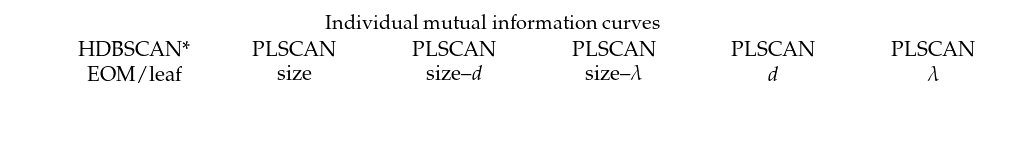

In [17]:
# Create the plots
sized_fig(1, 0.45 / 6)
max_x = plot_df.k.max()
ticks = [0, 0.5, 1]
alg_idxs = [[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11]]
for j, ids in enumerate(alg_idxs):
    plt.subplot(1, 6, j + 1)
    plt.title(titles[j], y=0)
    plt.xlim(0, max_x)
    plt.xticks([0, 25, 50])
    plt.yticks([])
    plt.ylim(0, 1)
    if j == 0:
        plt.ylabel(f"{dataset_name(data_sets[0])}\nMutual info.", labelpad=0, color="w")
    plt.tick_params(axis="x", colors="white")
    plt.tick_params(axis="y", colors="white")
    plt.suptitle("Individual mutual information curves", y=1)
    plt.subplots_adjust(bottom=0, right=1, top=1, left=0.08, wspace=0.01)
    plt.savefig("images/parameter_sensitivity_header.pdf", pad_inches=0)

100%|██████████| 6307/6307 [49:20<00:00, 258.30it/s]

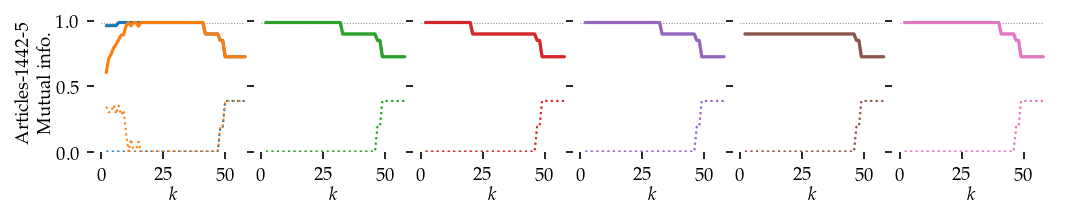

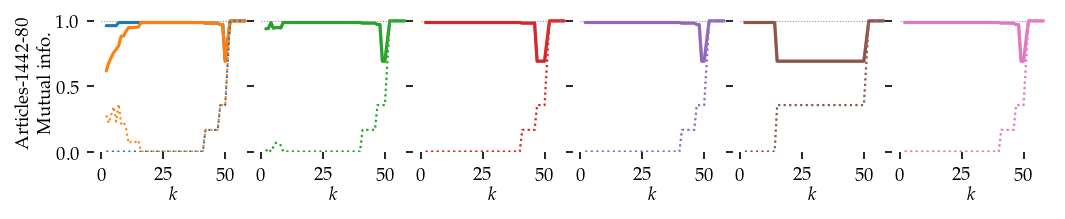

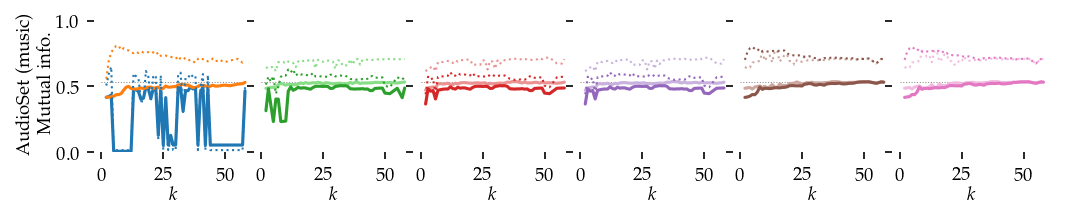

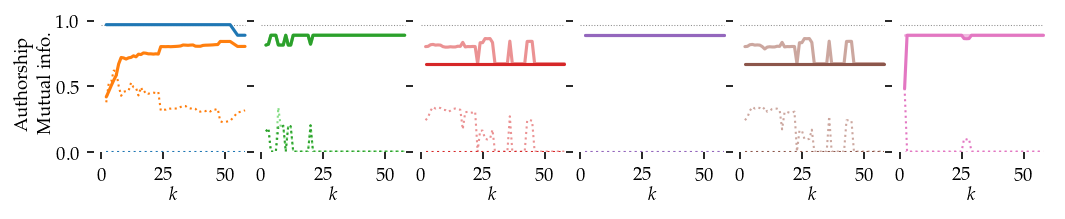

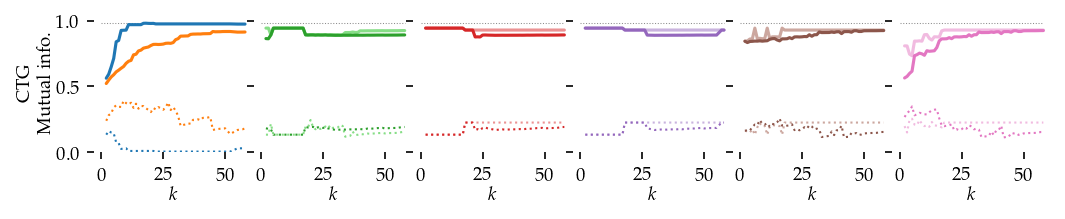

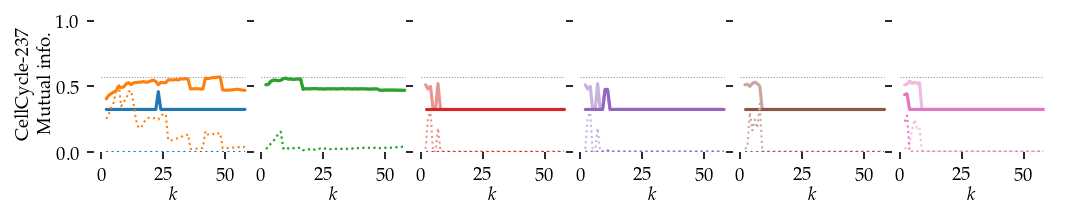

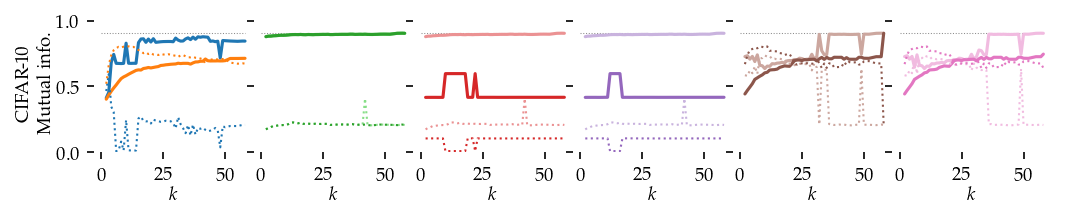

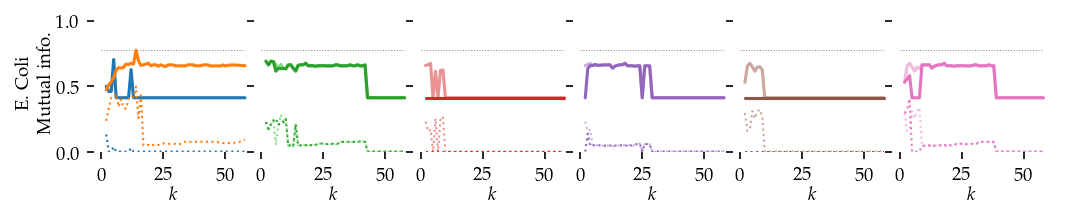

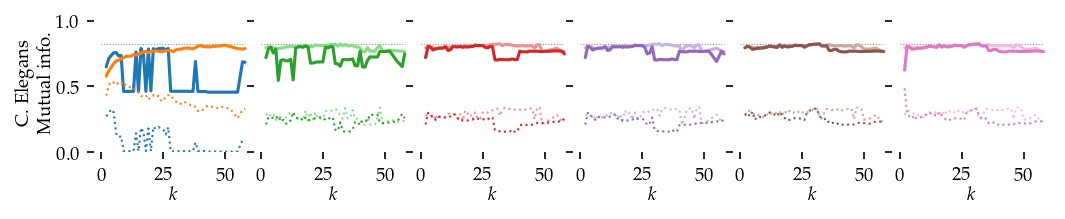

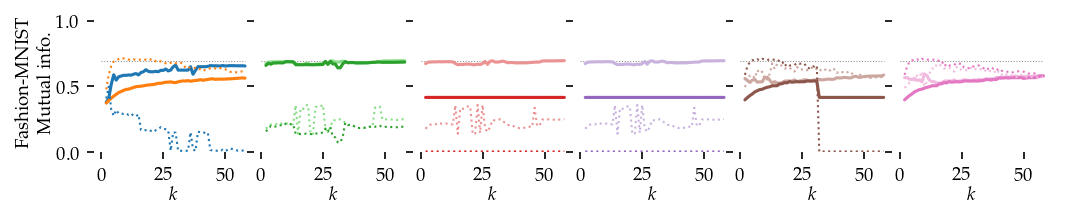

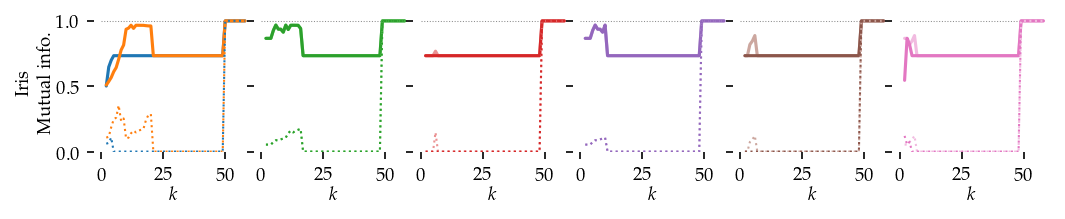

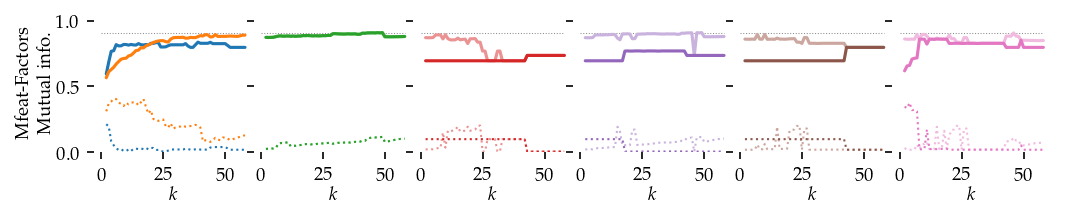

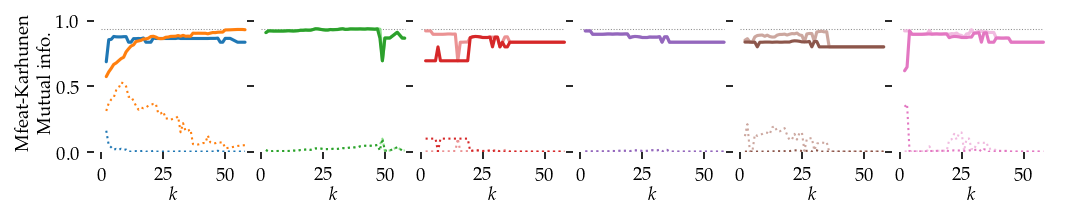

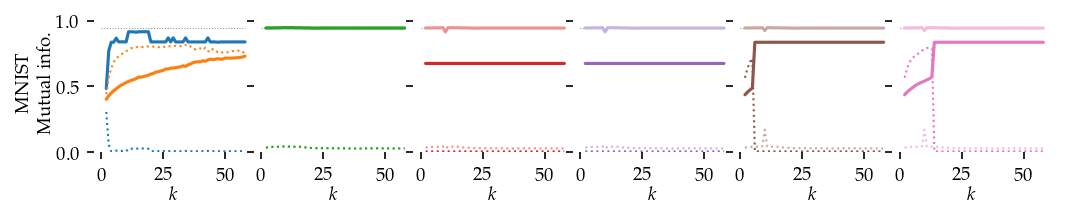

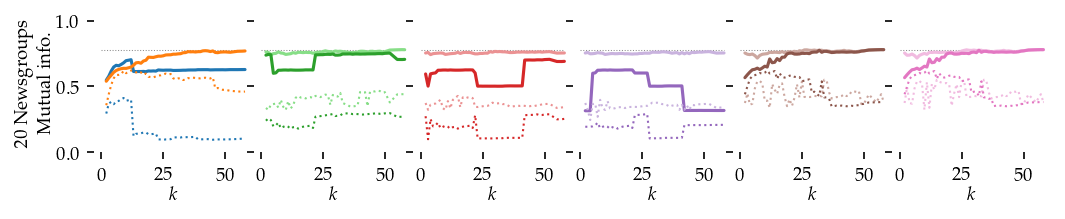

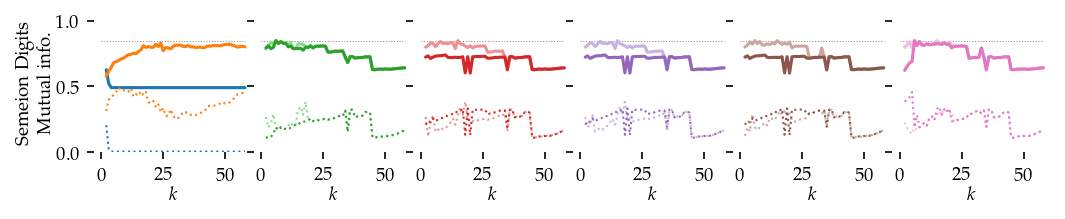

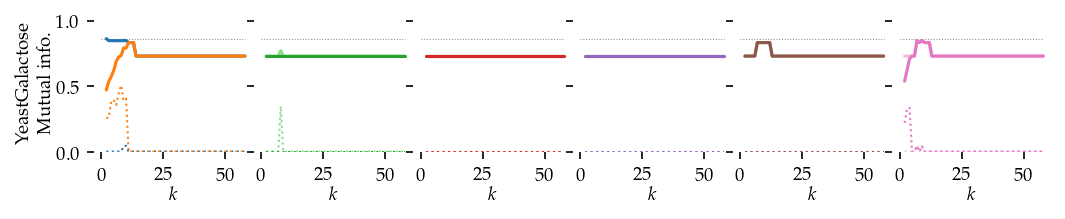

In [18]:
for i, data_name in enumerate(data_sets):
    sized_fig(1, 1.1 / 6)
    ddf = plot_df.query(f'data_set == "{data_name}"')
    max_x = ddf.k.max()
    max_y = ddf.mutual_info.max()
    for j, ids in enumerate(alg_idxs):
        plt.subplot(1, 6, j + 1)
        plt.hlines(
            max_y,
            0,
            max_x,
            colors=lighten("k"),
            linestyles=":",
            linewidth=0.5,
        )
        sns.lineplot(
            data=ddf,
            x="k",
            y="mutual_info",
            hue="alg_id",
            hue_order=[alg_ids[idx] for idx in ids],
            errorbar=None,
            palette=[palette[idx] for idx in ids],
            legend=False,
        )
        sns.lineplot(
            data=ddf,
            x="k",
            y="noise_fraction",
            hue="alg_id",
            hue_order=[alg_ids[idx] for idx in ids],
            errorbar=None,
            palette=[palette[idx] for idx in ids],
            linestyle=":",
            linewidth=1,
            legend=False,
        )
        plt.xlabel("$k$", labelpad=0)
        plt.xticks([0, 25, 50])
        plt.ylim(0, 1.05)
        plt.yticks(ticks)
        if j == 0:
            plt.ylabel(f"{dataset_name(data_name)}\nMutual info.", labelpad=0)
        else:
            plt.ylabel("")
            plt.gca().set_yticklabels(["" for t in ticks])
        plt.subplots_adjust(bottom=0.26, right=1, left=0.08, wspace=0.01, top=0.98)
        plt.savefig(f"images/parameter_sensitivity_{data_name}.pdf", pad_inches=0)
plt.show()

Next, we summarize the shape of the curves over all datasets by Lowess
interpolation. We scaled the mutual information scores by the maximum value
achieved on each dataset to compare the curves, rather than the exact values.
Still, this interpolation has issues because some datasets need other $k$ values
to get good clusters.

In [19]:
def scale_quality(group):
    max_q = group.mutual_info.max()
    group["scaled_quality"] = group.mutual_info / max_q
    return group


plot_df = (
    plot_df.groupby(["data_set"])
    .apply(scale_quality, include_groups=False)
    .reset_index()
)

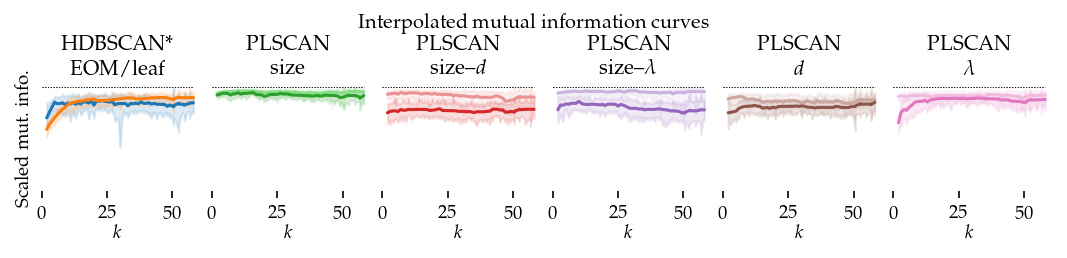

In [20]:
sized_fig(1, 1.3 / 6)
max_y = plot_df.scaled_quality.max()
for j, ids in enumerate(alg_idxs):
    plt.subplot(1, 6, j + 1)
    for i, idx in enumerate(ids):
        alg_id = alg_ids[idx]
        plt.hlines(max_y, 0, max_x, colors="k", linestyles=":", linewidth=0.5)
        regplot_lowess_ci(
            plot_df.query(f'alg_id == "{alg_id}"'),
            x="k",
            y="scaled_quality",
            ci_level=99,
            n_boot=100,
            lowess_frac=0.05,
            color=palette[idx],
            scatter=False,
        )
        plt.title(titles[j])
        plt.xlabel("$k$", labelpad=0)
        plt.ylim(0, 1)
        plt.yticks([])
        plt.xticks([0, 25, 50])
        if j == 0:
            plt.ylabel("Scaled mut.~info.", labelpad=0)
        else:
            plt.ylabel("")
plt.suptitle("Interpolated mutual information curves", y=1)
plt.subplots_adjust(bottom=0.22, right=1, left=0.02, wspace=0.02, top=0.68)
plt.savefig("images/parameter_sensitivity_scaled.pdf", pad_inches=0)
plt.show()

## 3. Compute sensitivity

Now, we actually compute and compare the sensitivity measure. The measure
describes how much  quality scores change when the $k$ parameter changes. So, it
already takes into account absolute quality differences between datasets.

In [21]:
sensitivity_records = []
for data_set, alg_id in product(df_top.data_set.unique(), df_top.alg_id.unique()):
    sub_df = df_top.query(f"data_set == '{data_set}' & alg_id == '{alg_id}'")
    mut_infos = defaultdict(lambda: np.nan, {k: v for k, v in zip(sub_df.k, sub_df.mutual_info)})
    lookup_fun = np.vectorize(lambda x: mut_infos[x])
    initial_mut_info = lookup_fun(min_sample_sizes)[np.newaxis, :, :]
    perturbed_mut_info = lookup_fun(new_values)
    with np.errstate(divide="ignore", invalid="ignore"):
        diff = np.abs((perturbed_mut_info - initial_mut_info) / (perturbed_mut_info + initial_mut_info))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        sensitivity = np.nanmean(diff, axis=(1, 2))
    for delta, sensitivity in zip(deltas[:, 0], sensitivity):
        sensitivity_records.append(
            {
                "data_set": data_set,
                "alg_id": alg_id,
                "perturbation": delta,
                "sensitivity": sensitivity,
            }
        )

# Convert to pandas
df_sens = pd.DataFrame.from_records(sensitivity_records)
df_sens.head()

,data_set,alg_id,perturbation,sensitivity
0,iris,plscan_size,2,0.019883
1,iris,plscan_size,5,0.034894
2,iris,plscan_size,10,0.057013
3,iris,plscan_distance,2,0.012289
4,iris,plscan_distance,5,0.012801


On these datasets, PLSCAN has a lower sensitivity to $k$ than HDBSCAN*. However,
Peng et al. classify all values below 0.25 as insensitive. 

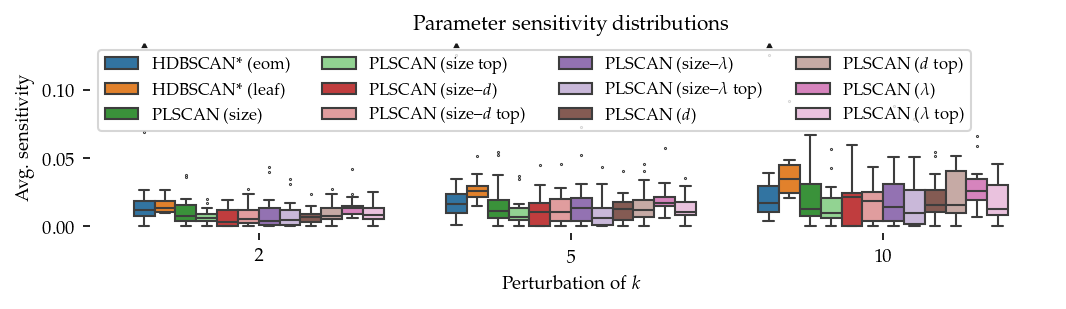

In [37]:
sized_fig(1, 0.8 / 3)

plot_df = df_sens.copy()
plot_df.alg_id = plot_df.alg_id.apply(to_display_name)

alg_order = [0, 1, 3, 2, 5, 4, 7, 6, 9, 8, 11, 10]
hue_order = [to_display_name(alg_ids[x]) for x in alg_order]
alg_palette = [palette[x] for x in alg_order]
ax = sns.boxplot(
    data=plot_df,
    y=plot_df.sensitivity,
    x=pd.Categorical(plot_df.perturbation),
    hue=plot_df.alg_id,
    hue_order=hue_order,
    palette=alg_palette,
    fliersize=0.5,
    linewidth=1,
    legend=True,
)
max_y = 0.135
plot_df.sensitivity > max_y
u_perts = plot_df.perturbation.unique().tolist()
for (alg_id, perturbation), _ in (
    plot_df[plot_df.sensitivity > max_y]
    .groupby(["alg_id", "perturbation"])
    .groups.items()
):
    pert_order = u_perts.index(perturbation)
    alg_order = hue_order.index(alg_id)
    w = 0.8/2
    o = pert_order - w + (alg_order) * w / 6 + w / 12
    plt.plot(o, max_y - 0.002, 'k^', markersize=1.5)

plt.yticks([0, 0.05, 0.1])
plt.ylim(-0.005, max_y)
plt.legend(ncol=4, title="", loc="upper left")
plt.xlabel("Perturbation of $k$")
plt.ylabel("Avg.~sensitivity")
plt.title("Parameter sensitivity distributions")
plt.subplots_adjust(left=0.075, right=1, bottom=0.21, top=0.9)
plt.savefig("images/parameter_sensitivity_boxplot.pdf", pad_inches=0)
plt.show()

### Sensitivity on noise fractions

Changes in noise fractions more strongly indicate cluster selection differences
(?). There are only a few datasets with noise fraction curves where EOM
fluctuates stronger than leaf. Do those few datasets have such a strong effect
on the sensitivity measure?

In [31]:
noise_sensitivity_records = []
for data_set, alg_id in product(df_top.data_set.unique(), df_top.alg_id.unique()):
    sub_df = df_top.query(f"data_set == '{data_set}' & alg_id == '{alg_id}'")
    values = defaultdict(lambda: np.nan, {k: v for k, v in zip(sub_df.k, sub_df.noise_fraction)})
    lookup_fun = np.vectorize(lambda x: values[x])
    initial_values = lookup_fun(min_sample_sizes)[np.newaxis, :, :]
    perturbed_values = lookup_fun(new_values)
    with np.errstate(divide="ignore", invalid="ignore"):
        diff = np.abs((perturbed_values - initial_values) / (perturbed_values + initial_values))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        sensitivity = np.nanmean(diff, axis=(1, 2))
    for delta, sensitivity in zip(deltas[:, 0], sensitivity):
        noise_sensitivity_records.append(
            {
                "data_set": data_set,
                "alg_id": alg_id,
                "perturbation": delta,
                "sensitivity": sensitivity,
            }
        )

# Convert to pandas
df_noise_sens = pd.DataFrame.from_records(noise_sensitivity_records)
df_noise_sens.head()

,data_set,alg_id,perturbation,sensitivity
0,iris,plscan_size,2,0.291628
1,iris,plscan_size,5,0.542452
2,iris,plscan_size,10,0.855072
3,iris,plscan_distance,2,1.000000
4,iris,plscan_distance,5,0.800000


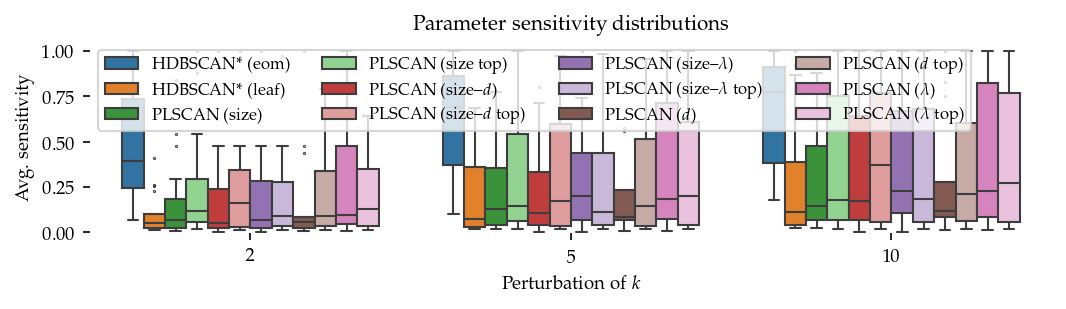

In [38]:
sized_fig(1, 0.8 / 3)

plot_df = df_noise_sens.copy()
plot_df.alg_id = plot_df.alg_id.apply(to_display_name)

ax = sns.boxplot(
    data=plot_df,
    y=plot_df.sensitivity,
    x=pd.Categorical(plot_df.perturbation),
    hue=plot_df.alg_id,
    hue_order=hue_order,
    palette=alg_palette,
    fliersize=0.5,
    linewidth=1,
    legend=True,
)
plt.ylim(-0.005, None)
plt.legend(ncol=4, title="", loc="upper left")
plt.xlabel("Perturbation of $k$")
plt.ylabel("Avg.~sensitivity")
plt.title("Parameter sensitivity distributions")
plt.subplots_adjust(left=0.075, right=1, bottom=0.21, top=0.9)
# plt.savefig("images/parameter_sensitivity_boxplot.pdf", pad_inches=0)
plt.show()